# Figure 009 (v001)

Synthetic lethal analysis

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Collection, Sequence

import janitor  # noqa: F401
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from matplotlib import cm
from matplotlib.text import Text
from scipy.cluster.hierarchy import leaves_list, linkage

In [3]:
from speclet.io import figure_img_file, tables_dir
from speclet.plot import PlottingMode, set_speclet_theme
from speclet.plot.color_pal import pal_to_legend_handles, sublineage_color_pal

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
set_speclet_theme(PlottingMode.DISSERTATION)
np.random.seed(0)

In [5]:
FIGNUM, VERSION = 9, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "synthetic-lethal")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_009-v001/fig_009-v001_synthetic-lethal.png')

In [6]:
nb_output_dir = tables_dir() / "100_120_cancer-gene-comut-analysis"

### Data

In [7]:
cancer_genes_X = pd.read_csv(nb_output_dir / "cancer-genes-per-lineage.csv").set_index(
    "lineage_subtype"
)
synlet_post = pd.read_csv(nb_output_dir / "synthetic-lethal-posterior.csv")
gene_effect_corrs = pd.read_csv(nb_output_dir / "gene-effect-covariance-posteriors.csv")
nsclc_smarca4_sl_hits_data = pd.read_csv(nb_output_dir / "lung-nsclc-smarca4-data.csv")

In [8]:
cancer_genes_X.index

Index(['bile duct (cholangiocarcinoma)', 'blood (ALL)', 'blood (AML)',
       'breast', 'central nervous system (glioma)',
       'central nervous system (medulloblastoma)', 'colorectal',
       'esophagus (esophagus squamous)', 'gastric (gastric adenocarcinoma)',
       'kidney (renal cell carcinoma)', 'liver (hepatocellular carcinoma)',
       'lung (NSCLC)', 'lung (SCLC)', 'ovary (ovary adenocarcinoma)',
       'pancreas', 'peripheral nervous system (neuroblastoma)',
       'urinary tract', 'uterus (endometrial adenocarcinoma)'],
      dtype='object', name='lineage_subtype')

## Figure

### Shared

In [9]:
FIGSIZE = (6.5, 7.5)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(nrows=3, ncols=1, height_ratios=(1, 1, 1))

top_row_panels = subfigures[0]
middle_row_panels = subfigures[1].subfigures(ncols=3, width_ratios=(1, 1, 1))
bottom_row = subfigures[2].subfigures(ncols=3, width_ratios=(2, 2, 4))

<Figure size 650x750 with 0 Axes>

In [10]:
def hclust(x: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    row_cls = linkage(x, method="average", metric="euclidean", optimal_ordering=True)
    col_cls = linkage(x.T, method="average", metric="euclidean", optimal_ordering=True)
    row_idx = leaves_list(row_cls)
    col_idx = leaves_list(col_cls)
    y = x.copy().iloc[row_idx, col_idx]
    return y, row_idx, col_idx

In [11]:
def short_cancers(t: str) -> str:
    replacements = {"adenocarcinoma": "adeno.", "carcinoma": "carc."}
    for k, v in replacements.items():
        t = t.replace(k, v)
    return t


def extract_subtype(t: str, shorten: bool = True) -> str:
    if "(" not in t:
        return t
    t = t.split("(")[1].replace(")", "").strip()
    if shorten:
        t = short_cancers(t)
    return t


def extract_subtypes(ts: Sequence[str], shorten: bool = True) -> list[str]:
    return [extract_subtype(t, shorten=shorten) for t in ts]


def extract_subtype_from_label(lbl: Text, shorten: bool = True) -> Text:
    lbl.set_text(extract_subtype(lbl.get_text(), shorten=shorten))
    return lbl


def extract_subtype_from_labels(
    lbls: Sequence[Text], shorten: bool = True
) -> list[Text]:
    return [extract_subtype_from_label(lbl, shorten=shorten) for lbl in lbls]

### a. Cancer genes per subtype

In [12]:
def _italicize_tick_labels(labels: list[Text]) -> list[Text]:
    new_labels: list[Text] = []
    for lbl in labels:
        lbl.set_text(r"$\textit{" + lbl.get_text() + "}$")
        new_labels.append(lbl)
    return new_labels

In [13]:
top_row_panels.clear()
top_row_panels.text(0, 0.98, r"$\textbf{a}$", fontsize=8, fontweight="bold")
top_row_panels.text(0.765, 0.98, r"$\textbf{b}$", fontsize=8, fontweight="bold")
top_row_axes = top_row_panels.subplots(
    ncols=2, gridspec_kw={"width_ratios": (3, 1)}, sharey=False
)

# Memo sort columns (keep row order alphabetical).
values = np.arange(cancer_genes_X.shape[0])[::-1].reshape(-1, 1)
values = np.tile(values, cancer_genes_X.shape[1]) + 1
gene_order = (
    (cancer_genes_X * values**2).sum(axis=0).sort_values(ascending=False).index
)
cancer_genes_X_cls = cancer_genes_X[gene_order]

ax = top_row_axes[0]
sns.heatmap(
    data=cancer_genes_X_cls,
    cmap="Greys",
    cbar=None,
    xticklabels=1,
    yticklabels=1,
    ax=ax,
)
ax.set_xlabel(None)
ax.set_ylabel(None)

for i in range(len(cancer_genes_X_cls) + 1):
    ax.axhline(i, c="grey", lw=0.25, zorder=10)
for i in range(cancer_genes_X_cls.shape[1] + 1):
    ax.axvline(i, c="grey", lw=0.25, zorder=10)

ax.set_yticklabels(extract_subtype_from_labels(ax.get_yticklabels()))
ax.set_xticklabels(_italicize_tick_labels(ax.get_xticklabels()))
ax.tick_params(labelsize=5.5, pad=1)

### b. distribution of $h$ posterior means

In [14]:
ax = top_row_axes[1]
ax.clear()

sns.violinplot(
    data=synlet_post,
    x="mean_h",
    y="lineage_subtype",
    hue="lineage_subtype",
    palette=sublineage_color_pal(),
    dodge=False,
    linewidth=0.5,
    ax=ax,
    zorder=10,
    saturation=1,
)

if (leg := ax.get_legend()) is not None:
    leg.remove()

ax.set_yticklabels([])
ax.set_xlabel(r"$\bar{h}$ posterior")
ax.set_ylabel(None)
ax.set_xlim(-1, 1)

(-1.0, 1.0)

### c. Correlated gene effects in CRC

In [15]:
panel_c = middle_row_panels[0]
panel_c.clear()
panel_c.text(0, 0.98, r"$\textbf{c}$", fontsize=8)
ax = panel_c.subplots()


crc_gene_corrs = gene_effect_corrs.query("lineage_subtype == 'colorectal'").reset_index(
    drop=True
)

new_vars = {"mu_a": r"\mu_a"}
for v in crc_gene_corrs["var1"].unique():
    if "h" not in v:
        continue
    g = v.split("_")[1]
    new_vars[v] = r"h_\textit{" + g + "}"

for c in ["var1", "var2"]:
    crc_gene_corrs[c] = [f"${new_vars.get(v, v)}$" for v in crc_gene_corrs[c]]

crc_gene_corrs = crc_gene_corrs.pivot_wider(
    "var1", names_from="var2", values_from="mean"
).set_index("var1")
sns.heatmap(
    data=crc_gene_corrs,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    ax=ax,
    square=True,
    cbar_kws={"label": "corr.", "location": "bottom"},
)
ax.set_ylabel(None)

Text(2.1965808368664987, 0.5, '')

### d. PIK3CA and KRAS full joint syn. let. distribution

In [16]:
panel_d = middle_row_panels[1]
panel_d.clear()
panel_d.text(0, 0.98, r"$\textbf{d}$", fontsize=8, fontweight="bold")
ax = panel_d.subplots()

crc_pik3ca_kras = (
    synlet_post.copy()
    .query("lineage_subtype == 'colorectal'")
    .filter_column_isin("cancer_gene", ["KRAS", "PIK3CA"])
)

zero_mu_a_hdi_genes = crc_pik3ca_kras["hdi_zero_mu_a"].toset()
plot_df = crc_pik3ca_kras.pivot_wider(
    ["hugo_symbol", "mean_mu_a", "hdi_zero_mu_a"],
    names_from="cancer_gene",
    values_from="mean_h",
).sort_values("hdi_zero_mu_a")


color_pal = {True: "tab:blue", False: "grey"}
alpha_pal = {True: 0.5, False: 0.9}
cmap = sns.color_palette("icefire", as_cmap=True)
norm = colors.CenteredNorm(0, plot_df["mean_mu_a"].abs().max() * 0.5)
sns.scatterplot(
    data=plot_df,
    x="KRAS",
    y="PIK3CA",
    c=plot_df["mean_mu_a"],
    ax=ax,
    s=3,
    alpha=0.8,
    cmap=cmap,
    norm=norm,
    zorder=10,
)
ax.set_xlabel(r"$\textit{KRAS}$ comutation eff.")
ax.set_ylabel(r"$\textit{PIK3CA}$ comutation eff.")
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
scalarmappaple.set_array(plot_df["mean_mu_a"])
cbar = panel_c.colorbar(scalarmappaple, location="top", label=r"$\mu_a$")
cbar.outline.set_visible(False)

ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)

### e. PIK3CA and KRAS joint syn. let. distribution of non-essential genes

In [17]:
panel_e = middle_row_panels[2]
panel_e.clear()
panel_e.text(0, 0.98, r"$\textbf{e}$", fontsize=8, fontweight="bold")
ax = panel_e.subplots()


def _assign_labels_for_kras_pik3ca_hdi_zero(df: pd.DataFrame) -> pd.DataFrame:
    lbl = []
    for _, x in df.iterrows():
        kras, pik3ca = not x["hdi_zero_h_KRAS"], not x["hdi_zero_h_PIK3CA"]
        if kras and pik3ca:
            lbl.append("both")
        elif kras:
            lbl.append("KRAS")
        elif pik3ca:
            lbl.append("PIK3CA")
        else:
            lbl.append("neither")
    df["label"] = lbl
    return df


zero_mu_a_hdi_genes = crc_pik3ca_kras["hdi_zero_mu_a"].toset()
plot_df = (
    crc_pik3ca_kras.query("hdi_mu_mu_a")
    .pivot_wider(
        "hugo_symbol",
        names_from="cancer_gene",
        values_from=["mean_h", "hdi_zero_h"],
    )
    .pipe(_assign_labels_for_kras_pik3ca_hdi_zero)
)

if np.any(plot_df["label"] == "both"):
    raise BaseException("Need to add color pal for 'both' label.")
e_color_pal = {
    "KRAS": "tab:blue",
    "PIK3CA": "tab:red",
    "neither": "tab:grey",
}
e_alpha_pal = {"neither": 0.5}
e_size_pal = {"neither": 2}
for val, df in plot_df.groupby("label"):
    sns.scatterplot(
        data=df,
        x="mean_h_KRAS",
        y="mean_h_PIK3CA",
        hue="label",
        palette=e_color_pal,
        ax=ax,
        alpha=e_alpha_pal.get(val, 1),
        s=e_size_pal.get(val, 3),
        zorder=10,
        legend=False,
        edgecolor=None,
    )

ax.set_xlabel(r"$\textit{KRAS}$ comutation eff.")
ax.set_ylabel(r"$\textit{PIK3CA}$ comutation eff.")
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)

e_mod_pal = {
    r"$\textit{KRAS}$": e_color_pal["KRAS"],
    r"$\textit{PIK3CA}$": e_color_pal["PIK3CA"],
    "neither": e_color_pal["neither"],
}
leg = ax.legend(
    handles=pal_to_legend_handles(e_mod_pal, lw=0, marker="o", markersize=2),
    title="synthetic lethal interaction",
    loc="upper center",
    borderpad=0,
    labelspacing=0,
    bbox_to_anchor=(0.5, 1.13),
    ncol=3,
    handletextpad=0.5,
    handlelength=0,
    columnspacing=1,
)

### f. Ranked SL for NSCLC

In [18]:
panel_f = bottom_row[0]
panel_f.clear()
panel_f.text(0, 0.98, r"$\textbf{f}$", fontsize=8, fontweight="bold")
ax = panel_f.subplots()


LINEAGE = "lung (NSCLC)"
CANCER_GENE = "SMARCA4"
SL_GENE = "SMARCA2"


def _assign_labels_for_nsclc_ranked_plot(df: pd.DataFrame) -> pd.DataFrame:
    lbl = []
    for _, x in df.iterrows():
        if x["hugo_symbol"] == SL_GENE:
            lbl.append("known-SL")
        elif x["mean_h"] < -0.06 or 0.06 < x["mean_h"]:
            lbl.append("top")
        else:
            lbl.append("regular")
    df["label"] = pd.Categorical(lbl, categories=["known-SL", "top", "regular"])
    return df


nsclc_synlet_ranked = (
    synlet_post.query(
        f"lineage_subtype == '{LINEAGE}' and cancer_gene == '{CANCER_GENE}'"
    )
    .query("hdi_mu_mu_a")
    .sort_values("mean_h", ascending=False)
    .assign(order=lambda d: np.arange(len(d)))
    .reset_index(drop=True)
    .pipe(_assign_labels_for_nsclc_ranked_plot)
    .sort_values("label", ascending=False)
)
sns.scatterplot(
    data=nsclc_synlet_ranked,
    x="order",
    y="mean_h",
    hue="label",
    palette={"known-SL": "tab:red", "top": "k", "regular": "lightgrey"},
    zorder=10,
    alpha=0.9,
    s=3,
    edgecolor=None,
    ax=ax,
    legend=False,
)
ax.set_title("NSCLC", pad=3)
ax.axhline(0, lw=0.5, c="k", zorder=1)
ax.set_xlabel(None)
ax.set_ylabel(r"$\bar{h}_\textit{SMARCA4}$")
ax.set_xticks([])

nsclc_hits = nsclc_synlet_ranked.query("mean_h < -0.06")["hugo_symbol"].tolist()
nsclc_hits += nsclc_synlet_ranked.query("mean_h > 0.06")["hugo_symbol"].tolist()
texts = []
for hit in nsclc_hits:
    d = nsclc_synlet_ranked.query(f"hugo_symbol == '{hit}'")
    txt = ax.text(
        d["order"].values[0],
        d["mean_h"].values[0],
        r"$\textit{" + hit + "}$",
        size=6,
        zorder=20,
        fontstyle="italic",
    )
    texts.append(txt)

np.random.seed(194)
adjust_text(texts, ax=ax, arrowprops={"arrowstyle": "-", "color": "black", "lw": 0.5})

94

<Figure size 640x480 with 0 Axes>

### g. NSCLC SL in SCLC

In [19]:
panel_g = bottom_row[1]
panel_g.clear()
panel_g.text(0, 0.98, r"$\textbf{g}$", fontsize=8, fontweight="bold")
ax = panel_g.subplots()


LINEAGE = "lung (SCLC)"
CANCER_GENE = "SMARCA4"
SL_GENE = "SMARCA2"


def _assign_labels_for_sclc_ranked_plot(
    df: pd.DataFrame, nsclc_hits: Collection[str]
) -> pd.DataFrame:
    lbl = []
    for _, x in df.iterrows():
        if x["hugo_symbol"] == SL_GENE:
            lbl.append("known-SL")
        elif x["hugo_symbol"] in nsclc_hits:
            lbl.append("top")
        else:
            lbl.append("regular")
    df["label"] = pd.Categorical(lbl, categories=["known-SL", "top", "regular"])
    return df


sclc_synlet_ranked = (
    synlet_post.query(
        f"lineage_subtype == '{LINEAGE}' and cancer_gene == '{CANCER_GENE}'"
    )
    .query("hdi_mu_mu_a")
    .sort_values("mean_h", ascending=False)
    .assign(order=lambda d: np.arange(len(d)))
    .reset_index(drop=True)
    .pipe(_assign_labels_for_sclc_ranked_plot, nsclc_hits=nsclc_hits)
    .sort_values("label", ascending=False)
)

sns.scatterplot(
    data=sclc_synlet_ranked,
    x="order",
    y="mean_h",
    hue="label",
    palette={"known-SL": "tab:red", "top": "k", "regular": "lightgrey"},
    zorder=10,
    alpha=0.9,
    s=3,
    edgecolor=None,
    ax=ax,
    legend=False,
)
ax.set_title("SCLC", pad=3)
ax.axhline(0, lw=0.5, c="k", zorder=1)
ax.set_xlabel(None)
ax.set_ylabel(r"$\bar{h}_\textit{SMARCA4}$")
ax.set_xticks([])

texts = []
for hit in nsclc_hits:
    d = sclc_synlet_ranked.query(f"hugo_symbol == '{hit}'")
    txt = ax.text(
        d["order"].values[0],
        d["mean_h"].values[0],
        rf"$\textit{{{hit}}}$",
        size=6,
        zorder=20,
        fontstyle="italic",
    )
    texts.append(txt)

np.random.seed(194)
adjust_text(texts, ax=ax, arrowprops={"arrowstyle": "-", "color": "black", "lw": 0.5})

17

<Figure size 640x480 with 0 Axes>

### h. Raw data for SL hits with SMARCA4 in NSCLC

In [20]:
syn_viable = nsclc_synlet_ranked.query("mean_h > 0.06")["hugo_symbol"]
syn_lethal = nsclc_synlet_ranked.query("mean_h < -0.06")["hugo_symbol"]

panel_h = bottom_row[2]
panel_h.clear()
panel_h.text(0, 0.98, r"$\textbf{h}$", fontsize=8, fontweight="bold")
axes = panel_h.subplots(
    ncols=2,
    sharey=True,
    gridspec_kw={"width_ratios": (len(syn_viable), len(syn_lethal))},
)

pal = {False: "tab:grey", True: "tab:orange"}
labeled_pal = {"WT": "tab:grey", "mut.": "tab:orange"}

for ax, genes in zip(axes, [syn_viable, syn_lethal]):
    df = nsclc_smarca4_sl_hits_data.filter_column_isin("hugo_symbol", genes).assign(
        hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=genes)
    )
    sns.boxplot(
        data=df,
        x="hugo_symbol",
        y="lfc",
        hue="cg_mut",
        palette=pal,
        ax=ax,
        dodge=True,
        showfliers=True,
        fliersize=0.7,
        linewidth=0.7,
        boxprops={"zorder": 10},
        saturation=1,
        zorder=10,
    )
    ax.axhline(0, lw=0.5, c="k", zorder=1)
    ax.set_xticklabels(_italicize_tick_labels(ax.get_xticklabels()), rotation=90)
    ax.get_legend().remove()
    ax.set_xlabel(None)
    ax.set_ylabel(None)

axes[0].set_ylabel("log-fold change")
axes[0].set_title("synthetic viable")
axes[1].set_title("synthetic lethal")
leg = axes[1].legend(
    handles=pal_to_legend_handles(labeled_pal, lw=0, marker="s", markersize=3),
    title=r"$\textit{SMARCA4}$",
    labelspacing=0.7,
    handlelength=0,
    handletextpad=0.5,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

## Saving

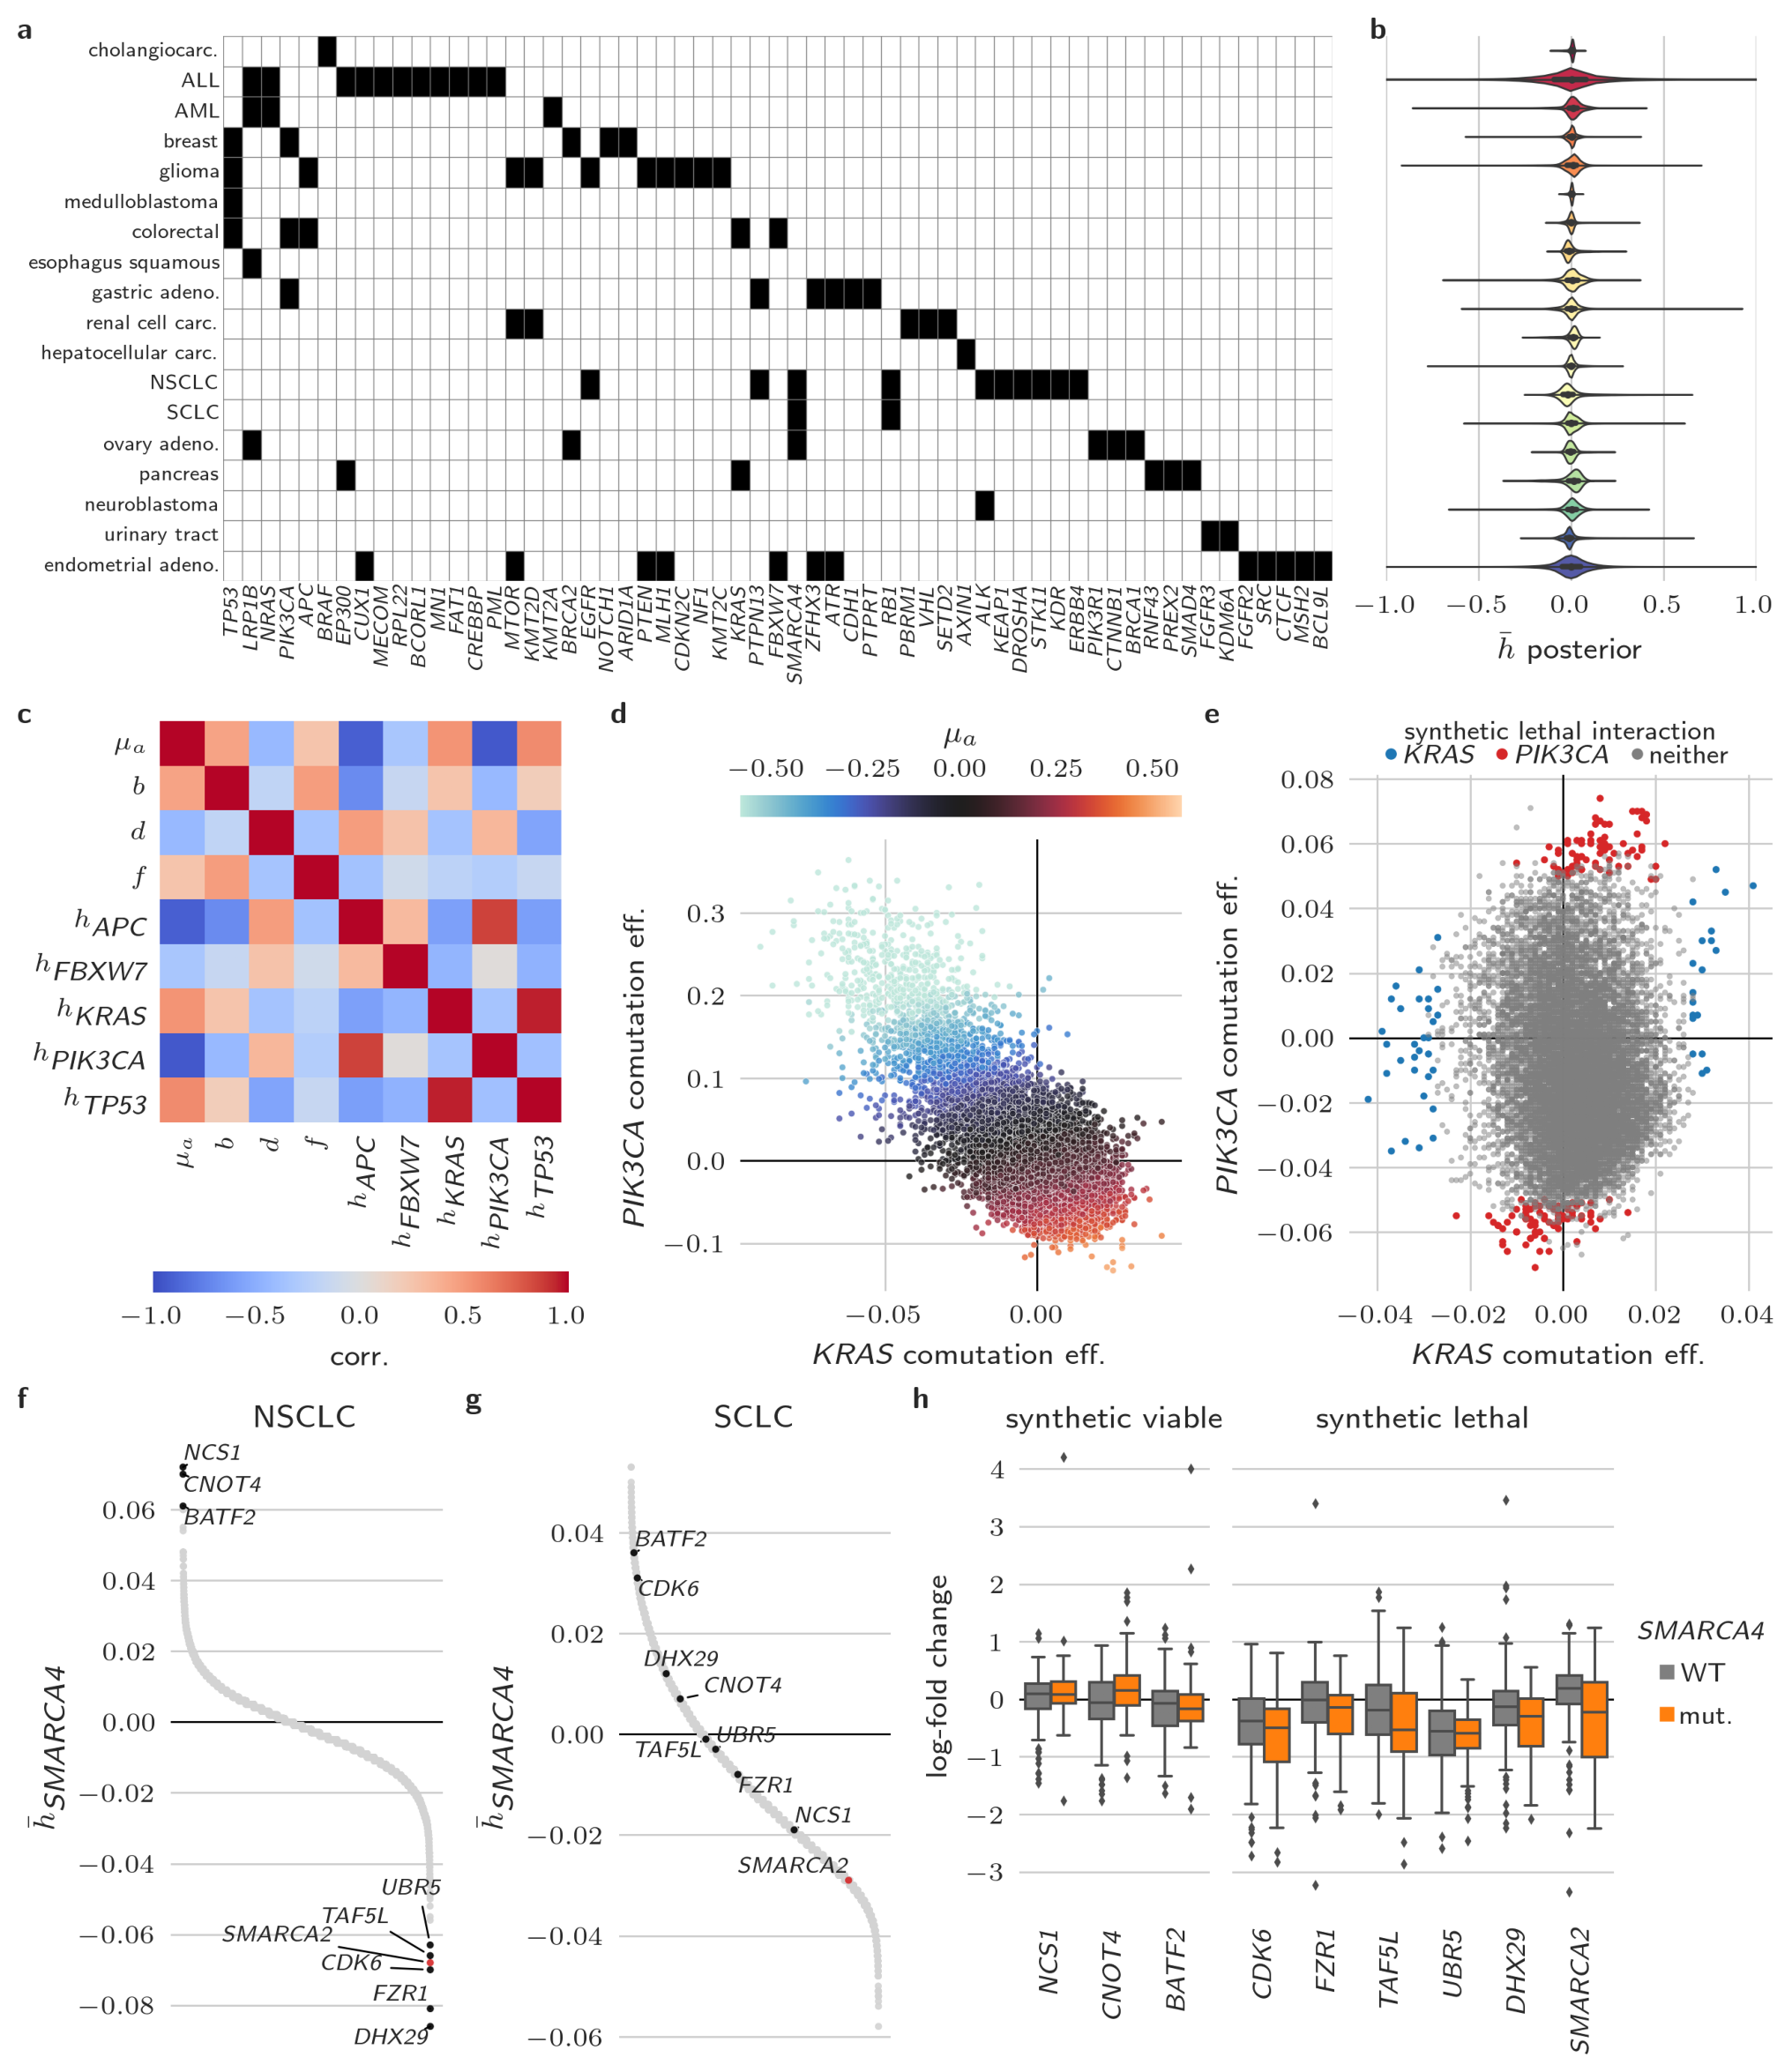

In [21]:
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0, bbox_inches="tight")

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Old components

In [22]:
# panel_g = bottom_row[1]
# panel_g.clear()
# panel_g.text(0, 0.98, "g", fontsize=8, fontweight="bold")
# ax = panel_g.subplots()

# ax.axhline(0, c="k", lw=0.5, zorder=1)
# ax.axvline(0, c="k", lw=0.5, zorder=1)

# lung_smarca4 = (
#     synlet_post.copy()
#     .query("cancer_gene == 'SMARCA4'")
#     .filter_string("lineage_subtype", "lung")
#     .reset_index(drop=True)
# )
# _genes = lung_smarca4.query("hdi_zero_mu_a")["hugo_symbol"].toset()
# print(f"number of genes: {len(_genes)}")
# plot_df = lung_smarca4.filter_column_isin("hugo_symbol", _genes).pivot_wider(
#     "hugo_symbol", names_from="lineage_subtype", values_from="mean_h"
# )
# x, y = "lung (NSCLC)", "lung (SCLC)"

# hits = plot_df.query(f"`{x}` < -0.06")["hugo_symbol"].tolist()
# hits += plot_df.query(f"`{x}` > 0.075")["hugo_symbol"].tolist()
# hits += plot_df.query(f"`{y}` < -0.1")["hugo_symbol"].tolist()
# hits += plot_df.query(f"`{y}` > 0.15")["hugo_symbol"].tolist()

# plot_df["hit"] = plot_df["hugo_symbol"].isin(hits)
# g_pal = {False: "tab:grey", True: "tab:blue"}
# g_alpha_pal = {False: 0.5, True: 1.0}
# g_size_pal = {False: 3, True: 5}
# g_zorder_pal = {False: 1, True: 5}
# for lbl, df in plot_df.groupby("hit"):
#     sns.scatterplot(
#         data=df,
#         x=x,
#         y=y,
#         hue="hit",
#         palette=g_pal,
#         edgecolor=None,
#         s=g_size_pal[lbl],
#         alpha=g_alpha_pal[lbl],
#         ax=ax,
#         zorder=g_zorder_pal[lbl],
#         legend=False,
#     )


# texts = []
# for hit in hits:
#     d = plot_df.query(f"hugo_symbol == '{hit}'")
#     txt = ax.text(
#         d[x].values[0], d[y].values[0], hit, size=6, zorder=20, fontstyle="italic"
#     )
#     texts.append(txt)

# np.random.seed(200)
# adjust_text(
#     texts,
#     ax=ax,
#     arrowprops={"arrowstyle": "-", "color": "black", "lw": 0.5, "zorder": 20},
# )

# ax.set_xlabel("NSCLC")
# ax.set_ylabel("SCLC")
# ax.set_title("SL with $SMARCA4$", pad=3)

---

## Session Info

In [23]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-23

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-236.o2.rc.hms.harvard.edu

Git branch: figures

matplotlib: 3.5.3
janitor   : 0.22.0
pandas    : 1.4.4
numpy     : 1.23.3
seaborn   : 0.11.2

